### Overview

In this project, I want to generate star trek scripts. Previously I tried to train locally to predict the next word, but ran into hardware issues. Now I am going to try instruction fine-tuning and Parameter Efficient Fine-tuning. I also think it might help to try to generate sequences (lines of dialog) rather than single word, since I can transfer that skill from other transformer models.

This time, let's try to use the FLAN-T5 model as our tokenizer and base model. We're now using Pytorch instead of tensorflow because I can adapt code to easily load the HuggingFace FLAN-T5 model.

In [1]:
!pip install transformers
!pip install transformers[torch]
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install loralib
!pip install peft
!pip install accelerate -U
!pip install tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 111.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=e3fc80c42e5eff64558ce0bc767d65fd5265a20c47b8cc95af

In [2]:
import json
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch

from datasets import Dataset, DatasetDict
import time
import evaluate
import pandas as pd

# from transformers import TFGPT2LMHeadModel, TFGPT2Model, GPT2Tokenizer, GPT2Config
# from transformers import DistilBertTokenizer, TFDistilBertModel
import re
from sklearn.model_selection import train_test_split
from random import randint
import matplotlib.pyplot as plt

import string
import random

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers import TextVectorization
# from tensorflow.keras.callbacks import ModelCheckpoint

# print(tf.__version__)

In [3]:
f = open("all_scripts_raw.json")
json_file = json.load(f)
f.close()
#start with TOS: might be more manageable
TOS_scripts=json_file['TOS']
print(TOS_scripts['episode 3'][:2000])







The Star Trek Transcripts - Where No Man Has Gone Before


Where
No Man Has Gone Before
Stardate:
1312.4
Original Airdate: 22 Sep, 1966







 
Captain's log, Star date 1312.4. The impossible has happened. From
directly ahead, we're picking up a recorded distress signal, the call
letters of a vessel which has been missing for over two centuries. Did
another Earth ship once probe out of the galaxy as we intend to do?
What happened to it out there? Is this some warning they've left
behind?

[Briefing room]

SPOCK: Your move, Captain. 
KIRK: We should have intercepted by now. The Bridge said they'd call. 
SPOCK: I'll have you checkmated your next move. 
KIRK: Have I ever mentioned you play a very irritating game of chess,
Mister Spock? 
SPOCK: Irritating? Ah, yes. One of your Earth emotions. 
KIRK: Certain you don't know what irritation is? 
SPOCK: The fact one of my ancestors married a human female 
KIRK: Terrible having bad blood like that. 
KELSO [on monitor] Bridge to briefing 

### General plan

I want to generate a star trek script. The input is one line of dialog (or stage direction), the output is the next line. Since we're trying to instruction-tune FLAN-T5, I don't want to introduce custom tokens. Hopefully it figures out what is dialog and what is stage direction.

To make this, that means I need to:
- parse the scripts, separating by line

- Remove episode title at beginning and copyright stuff at the end.
    
- Create segments of line, next line pairs

- Embed the wordings

- Split train/test data

- Create model and train
    


In [24]:
#functions to remove metadata and split script

def remove_metadata(script):
    # Find the position of the 17th newline character
    start_pos = -1
    for _ in range(17):
        start_pos = script.find('\n', start_pos + 1)

    # Slice the string from the character after the next newline
    if start_pos != -1:
        script = script[start_pos + 1:]

    # Find the position of "<Back"
    pos = script.find("<Back")

    # If found, cut off everything past that point
    if pos != -1:
        script = script[:pos]
    return script


def parse_lines(script_string, full_script_meta=True):
    #remove metadata
    if full_script_meta:
      script_string=remove_metadata(script_string)

    # Expression to look for newline, then one or more uppercase characters, possibly followed by a space and a character in square brackets then a colon
    # or a newline followed by a character in square brackets
    pattern = r"(?=\n[A-Z]+(?: \[[^\]]+\])?:|\n\[[^\]]+\])"


    # Use re.split to break the string at each match
    split_script = re.split(pattern, script_string)
    parsed_script=[clean_single_line(line) for line in split_script]
    #add END OF EPISODE to the end of the script
    if full_script_meta:
      parsed_script.append('END OF EPISODE')

    return parsed_script

def clean_single_line(line):
    #remove \r\n and \r and \n from each line, remove whitespace from beginning and end
    line=line.replace("\r\n", " ")
    line=line.replace("\r", "")
    line=line.replace("\n", "")
    return line.strip()

def recombine_lines(script_lines):
    return "\n".join(script_lines)

i=3
parsed_script=parse_lines(TOS_scripts['episode '+str(i)])
for j in range(0,20):
    print(parsed_script[j])
    # print('\n')
# print(recombine_lines(parsed_script))

print(parsed_script[-20:])

Captain's log, Star date 1312.4. The impossible has happened. From directly ahead, we're picking up a recorded distress signal, the call letters of a vessel which has been missing for over two centuries. Did another Earth ship once probe out of the galaxy as we intend to do? What happened to it out there? Is this some warning they've left behind?
[Briefing room]
SPOCK: Your move, Captain.
KIRK: We should have intercepted by now. The Bridge said they'd call.
SPOCK: I'll have you checkmated your next move.
KIRK: Have I ever mentioned you play a very irritating game of chess, Mister Spock?
SPOCK: Irritating? Ah, yes. One of your Earth emotions.
KIRK: Certain you don't know what irritation is?
SPOCK: The fact one of my ancestors married a human female
KIRK: Terrible having bad blood like that.  KELSO [on monitor] Bridge to briefing lounge. Object is now within tractor beam range.
KIRK: No visual contact, Mister Kelso?
KELSO [on monitor]: No, sir. It's too small to be a vessel. It only read

In [5]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
j=0
line_1in = parsed_script[j]
line_2in = parsed_script[j+1]
line_3in = parsed_script[j+2]
line_4in = parsed_script[j+3]
next_line = parsed_script[j+4]

prompt = f"""
Predict the next line of this script:

{line_1in}

{line_2in}

{line_3in}

{line_4in}

"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'ACTUAL NEXT LINE:\n{next_line}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Predict the next line of this script:

Captain's log, Star date 1312.4. The impossible has happened. From directly ahead, we're picking up a recorded distress signal, the call letters of a vessel which has been missing for over two centuries. Did another Earth ship once probe out of the galaxy as we intend to do? What happened to it out there? Is this some warning they've left behind?

[Briefing room]

SPOCK: Your move, Captain.

KIRK: We should have intercepted by now. The Bridge said they'd call.


---------------------------------------------------------------------------------------------------
ACTUAL NEXT LINE:
SPOCK: I'll have you checkmated your next move.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
KIRK: You're right.


#### Some thoughts on training and test
I can now take the scripts and create a set of prompt+next line pairs. Based on tinkering with the above cell, I'm going to try giving it four lines and asking it to predict the fifth.

### Process scripts and chunk into training and test sets
My previous experimentation found that overfitting wasn't as dangerous for this application as for most, and so maybe I should change the layout, but for now I'll start with the standard 10% validation, 20% test data.



In [7]:
# Load scripts and split into training and test sets
scripts=[TOS_scripts['episode '+str(i)] for i in range(len(TOS_scripts))]
random_state=42

train_scripts, test_scripts = train_test_split(scripts, test_size=0.2, random_state=random_state)
train_scripts, val_scripts = train_test_split(train_scripts, test_size=1/8, random_state=random_state)  # 10% of 80% = 1/8

#### A note about the parsed scripts at the end of an episode
The episode can end in the middle of a set of 5 lines. If this happens, it is thrown out. This means that it is rare that the END OF EPISODE line comes up as a target, so it will probably be difficult to learn. It does sometimes come up though.


In [8]:
# Use the parse_lines function to parse the scripts, creating a list of lists of lines
train_parsed = [parse_lines(script) for script in train_scripts]
val_parsed = [parse_lines(script) for script in val_scripts]
test_parsed = [parse_lines(script) for script in test_scripts]
print(f'Train scripts: {len(train_parsed)}')
print(f'Validation scripts: {len(val_parsed)}')
print(f'Test scripts: {len(test_parsed)}')

# Function to create a set of i input lines and the next line as the target, without repeats counting in steps of i
def create_dataset(parsed_scripts, i):
    target_lines = []
    prompt_lines = []
    for script in parsed_scripts:
        for j in range(0, len(script)-i, i):
            input_line=recombine_lines(script[j:j+i])
            target_lines.append(script[j+i])
            prompt_lines.append(f"Predict the next line of this script:\n\n{input_line}")
    return target_lines, prompt_lines


train_target_lines, train_prompt_lines= create_dataset(train_parsed, 4)
print(train_prompt_lines[0])
print(train_target_lines[0])
print('\n')
# An example of the END OF EPISODE target actually appearing
print(train_prompt_lines[76])
print(train_target_lines[76])
print('\n')

val_target_lines, val_prompt_lines= create_dataset(val_parsed, 4)
test_target_lines, test_prompt_lines= create_dataset(test_parsed, 4)



Train scripts: 56
Validation scripts: 8
Test scripts: 16
Predict the next line of this script:

Captain's log, Star date 1312.4. The impossible has happened. From directly ahead, we're picking up a recorded distress signal, the call letters of a vessel which has been missing for over two centuries. Did another Earth ship once probe out of the galaxy as we intend to do? What happened to it out there? Is this some warning they've left behind?
[Briefing room]
SPOCK: Your move, Captain.
KIRK: We should have intercepted by now. The Bridge said they'd call.
SPOCK: I'll have you checkmated your next move.


Predict the next line of this script:

[Bridge]
KIRK: Captain's log, Star date 1313.8. Add to official losses, Doctor Elizabeth Dehner. Be it noted she gave her life in performance of her duty. Lieutenant Commander Gary Mitchell, same notation. I want his service record to end that way. He didn't ask for what happened to him.
SPOCK: I felt for him, too.
KIRK: I believe there's some hope fo

##### Some random musings for the future of LLMS for this application.

Often in literature, including in TV scripts, the resolution mirrors the introduction, or themes from earlier in the episode are referenced in the conclusion, e.g. in this episode, the first scene includes Spock derisively criticising human emotions, while in the last few lines, Spock says he feels for the man who died and Kirk says there's hope for Spock after all.

Since this version of the LLM only is given the previous few lines, it will never be able to acheive this self-referential aspect of literature. Maybe in the future, one could create a network that saves to some internal reference, (kind of like an RNN) that this part here is important- save a summary of it in some embedding, that way we can reference it again later in a poetic way.

Too advanced for this kind of model, but something to think about.

In [34]:
# Convert to a dataset that PEFT will recognize
train_dataset = Dataset.from_dict({"target": train_target_lines, "prompt": train_prompt_lines})
test_dataset = Dataset.from_dict({"target": test_target_lines, "prompt": test_prompt_lines})
val_dataset = Dataset.from_dict({"target": val_target_lines, "prompt": val_prompt_lines})

# Create a dataset dictionary
dataset_dict = DatasetDict({"train": train_dataset, "test": test_dataset, "validation": val_dataset})
dataset_dict

# tokenize datasets
def tokenize_function(example):
    # start_prompt = 'Summarize the following conversation.\n\n'
    # end_prompt = '\n\nSummary: '
    prompts = [prompt for prompt in example["prompt"]]
    example['input_ids'] = tokenizer(prompts, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["target"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

tokenized_datasets['train']['prompt'][0]

Map:   0%|          | 0/5638 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

"Predict the next line of this script:\n\nCaptain's log, Star date 1312.4. The impossible has happened. From directly ahead, we're picking up a recorded distress signal, the call letters of a vessel which has been missing for over two centuries. Did another Earth ship once probe out of the galaxy as we intend to do? What happened to it out there? Is this some warning they've left behind?\n[Briefing room]\nSPOCK: Your move, Captain.\nKIRK: We should have intercepted by now. The Bridge said they'd call."

## Fine tune the original model using the scripts

We're going to use Parameter Efficient Fine Tuning (PEFT). PEFT allows us to fien tune the weights using Low-rank Adaptation (LoRA). Effectively, we will be using smaller matrices to modify the attention values rather than loading and training the full model, which is too big for my hardware.

### Results of previous attempts:
I used rank 4 for the matrices, and the model converged to a loss of about 0.14 after about 3 epochs and stayed flat for 10 epochs. The outputs frequently have character dialog, but that dialog almost always looks like a character saying "I'm not sure". I don't think the model is complex enough to capture more information. I've saved this model locally as model_rank4.zip.

The second attempt using rank 16 looked similar, but I forgot to save the validation set so I can't really check for overfitting. I'm gonna try rank 32 and save the validation set.

Rank 32 didn't perform much better than 16, but the validation set isn't done falling yet, so we should train longer.

In [10]:
from peft import LoraConfig, get_peft_model, TaskType
import accelerate

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

# Add LoRA adapter layers/parameters to the original LLM to be trained.
peft_model = get_peft_model(original_model,
                            lora_config)

def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(peft_model))


trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


In [13]:
from transformers import TrainerCallback, TrainerState, TrainingArguments, Trainer
log_list = [] #warning this line erases old log list
class LogLossCallback(TrainerCallback):
    def on_log(self, args: TrainingArguments, state: TrainerState, control, logs=None, **kwargs):
       log_list.append(logs)
       with open('logs.json', 'w', encoding='utf-8') as f:
            json.dump(log_list, f)

# Can modify the training arguments if you want, then start another training run

output_dir = f'./peft-next-line-training-{str(int(time.time()))}'
peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=10,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
)
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,

    callbacks=[LogLossCallback]
)

# peft_trainer.train("/content/peft-next-line-training-1698424854/checkpoint-500")
peft_trainer.train()


peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)


Step,Training Loss,Validation Loss
100,0.181900,0.154162
200,0.172800,0.151059
300,0.169700,0.146737
400,0.156200,0.145771
500,0.158400,0.143244
600,0.162800,0.141627
700,0.152200,0.140560
800,0.146200,0.139949
900,0.173000,0.147023
1000,0.160600,0.144922


('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

In [12]:
#continue training from peft_model_path instance
from transformers import TrainerCallback, TrainerState, TrainingArguments, Trainer
log_list = [] #warning this line erases old log list
peft_model_path="./peft-dialogue-summary-checkpoint-local"
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained(peft_model_path)
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

#set lora parameters to calculate gradients
for name, param in finetuned_model.named_parameters():
    if 'lora' in name:
        param.requires_grad = True

class LogLossCallback2(TrainerCallback):
    def on_log(self, args: TrainingArguments, state: TrainerState, control, logs=None, **kwargs):
       log_list.append(logs)
       with open('logs_run2.json', 'w', encoding='utf-8') as f:
            json.dump(log_list, f)
output_dir = f'./peft-next-line-training-{str(int(time.time()))}'
# Define the training arguments
peft_training_args = TrainingArguments(
    output_dir=output_dir,  # Make sure this is the directory for the new run
    auto_find_batch_size=True,
    num_train_epochs=10,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
)

# Initialize the Trainer with the fine-tuned model
peft_trainer = Trainer(
    model=finetuned_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    callbacks=[LogLossCallback2]
)

# Start training
finetuned_model.train()
peft_trainer.train()
peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,0.134800,0.132377
200,0.116200,0.132331
300,0.135600,0.132278
400,0.134400,0.132195
500,0.132200,0.132325
600,0.128900,0.132186
700,0.131800,0.132317
800,0.130700,0.132257
900,0.133900,0.132195
1000,0.130000,0.132245


/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:389: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:389: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:389: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:389: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:389: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.10/dist

('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

In [13]:
!zip -r /content/model.zip {peft_model_path}
from google.colab import files
files.download('/content/model.zip')
files.download('logs_run2.json')

  adding: peft-dialogue-summary-checkpoint-local/ (stored 0%)
  adding: peft-dialogue-summary-checkpoint-local/README.md (deflated 66%)
  adding: peft-dialogue-summary-checkpoint-local/tokenizer_config.json (deflated 94%)
  adding: peft-dialogue-summary-checkpoint-local/adapter_config.json (deflated 46%)
  adding: peft-dialogue-summary-checkpoint-local/special_tokens_map.json (deflated 85%)
  adding: peft-dialogue-summary-checkpoint-local/adapter_model.safetensors (deflated 7%)
  adding: peft-dialogue-summary-checkpoint-local/tokenizer.json (deflated 74%)
  adding: peft-dialogue-summary-checkpoint-local/adapter_model.bin (deflated 8%)
  adding: peft-dialogue-summary-checkpoint-local/generation_config.json (deflated 29%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={output_dir}


### Evaluate the model using ROUGE

In [11]:
# Load the most recent model checkpoint
!unzip model_rank32_run2.zip -d .
peft_model_path="./peft-dialogue-summary-checkpoint-local"
# from transformers import AutoModel
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained(peft_model_path)
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)


Archive:  model_rank32_run2.zip
   creating: ./peft-dialogue-summary-checkpoint-local/
  inflating: ./peft-dialogue-summary-checkpoint-local/README.md  
  inflating: ./peft-dialogue-summary-checkpoint-local/tokenizer_config.json  
  inflating: ./peft-dialogue-summary-checkpoint-local/adapter_config.json  
  inflating: ./peft-dialogue-summary-checkpoint-local/special_tokens_map.json  
  inflating: ./peft-dialogue-summary-checkpoint-local/adapter_model.safetensors  
  inflating: ./peft-dialogue-summary-checkpoint-local/tokenizer.json  
  inflating: ./peft-dialogue-summary-checkpoint-local/adapter_model.bin  
  inflating: ./peft-dialogue-summary-checkpoint-local/generation_config.json  


[{'loss': 0.1819, 'learning_rate': 0.0009858156028368795, 'epoch': 0.14}, {'eval_loss': 0.15416166186332703}, {'loss': 0.1728, 'learning_rate': 0.0009716312056737589, 'epoch': 0.28}, {'eval_loss': 0.15105919539928436}, {'loss': 0.1697, 'learning_rate': 0.0009574468085106384, 'epoch': 0.43}]


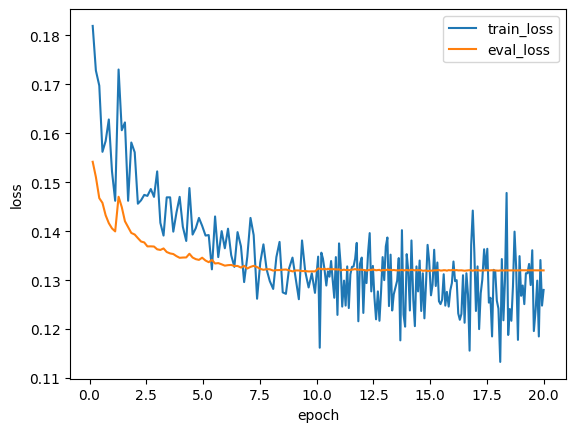

In [14]:
# load and plot the loss

epoch=[]
loss=[]
eval_loss=[]
with open('logs_rank32.json', 'r', encoding='utf-8') as f:
    log_list = json.load(f)
print(log_list[0:5])
for log in log_list:
    if 'loss' in log:
        loss.append(log['loss'])
        epoch.append(log['epoch'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

with open('logs_rank32_run2.json', 'r', encoding='utf-8') as f:
    log_list = json.load(f)
for log in log_list:
    if 'loss' in log:
        loss.append(log['loss'])
        epoch.append(log['epoch']+10)
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

import matplotlib
import matplotlib.pyplot as plt
plt.plot(epoch,loss)
plt.plot(epoch,eval_loss)
plt.legend(['train_loss','eval_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()






In [15]:
# Generate the outputs of the test dataset using the original FLAN-T5 model
first_n_lines = 15
original_model_nextlines = []
finetuned_model_nextlines = []
for prompt in test_prompt_lines[0:first_n_lines]:
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    input_ids = input_ids.to(original_model.device)
    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_nextlines.append(original_model_text_output)

    input_ids_gpu = input_ids.to(finetuned_model.device)
    peft_model_outputs = finetuned_model.generate(input_ids=input_ids_gpu, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)
    finetuned_model_nextlines.append(peft_model_text_output)

zipped_summaries = list(zip(test_target_lines[0:first_n_lines], original_model_nextlines, finetuned_model_nextlines))

df = pd.DataFrame(zipped_summaries, columns = ['test_target_lines', 'original_model_nextlines', 'finetuned_model_nextlines'])
df


,test_target_lines,original_model_nextlines,finetuned_model_nextlines
0,"KIRK: No, nothing in particular. Why ?","MCCOY: Yes, he is.",SPOCK: He's a man of a certain age. He's a man...
1,CHAPEL: (carrying a tray and sounding embarras...,MCCOY is worried about his son's behavior.,"KIRK: I'm sorry, Mister Spock."
2,CHAPEL: Oh.,Doctor McCoy.,CHAPEL: I'm sorry. I'm sorry. I'm sorry. I'm s...
3,"KIRK: Bones, I'm a busy man.",MCCOY tries to convince Spock that he's not hu...,"CHAPEL: Oh, I'm sorry. I'm sorry. I'm sorry. I..."
4,SPOCK [OC]: Poking and prying! If I want anyth...,MCCOY screams and screams.,"KIRK: I'm sorry, Mister Spock. I'm sorry, Mist..."
5,[Spock's quarters],No,"KIRK: Yes, sir."
6,"SPOCK: You have my request, Captain. Will you ...",KIRK has been a servant to the man.,SPOCK: I've been a servant to you.
7,"SPOCK: No. Nothing of that nature, Captain.",SPOCK may ask for leave.,SPOCK: I'm not sure. I'm not sure.
8,SPOCK: I need rest. I'm asking you to accept t...,KIRK is going to take his leave on Vulcan.,"SPOCK: I am not a doctor, Captain. I am a scie..."
9,"SULU [OC]: Aye, sir.","SULU: Yes, Captain.",SULU [OC]: Warp four.


In [16]:
rouge = evaluate.load('rouge')
original_model_results = rouge.compute(
    predictions=original_model_nextlines,
    references=test_target_lines[0:len(original_model_nextlines)],
    use_aggregator=True,
    use_stemmer=True,
)
print('ORIGINAL MODEL:')
print(original_model_results)

finetuned_model_results = rouge.compute(
    predictions=finetuned_model_nextlines,
    references=test_target_lines[0:len(original_model_nextlines)],
    use_aggregator=True,
    use_stemmer=True,
)
print('FINE-TUNED MODEL:')
print(finetuned_model_results)

ORIGINAL MODEL:
{'rouge1': 0.0673202614379085, 'rouge2': 0.0, 'rougeL': 0.06112978524743232, 'rougeLsum': 0.06018674136321195}
FINE-TUNED MODEL:
{'rouge1': 0.09053875417511781, 'rouge2': 0.024100156494522688, 'rougeL': 0.08915340131249222, 'rougeLsum': 0.09128049980322707}


In [64]:
#invent a script procedurally


first_4_lines = """
Captain's log, Star date 1312.4. We're arrived upon a planet with two warring factions who have both requested aid from the Federation. We hope to be able to negotiate a ceasefire.

[Bridge]

SULU: Entering orbit now Captain.

KIRK: Thank you Mister Sulu. Open a channel to the planetside authorities.
"""


def convert_to_prompt_tokens(parsed_lines):
    i=4
    prompt_lines=[]
    input_line=recombine_lines(parsed_lines[-i:])
    # print(input_line)
    prompt_line = (f"Predict the next line of this script:\n\n{input_line}")
    return tokenizer(prompt_line, padding="max_length", truncation=True, return_tensors="pt").input_ids

script=first_4_lines

for script_gen in range(10):
  parsed_lines=parse_lines(script, full_script_meta=False)
  input_ids=convert_to_prompt_tokens(parsed_lines)
  input_ids_gpu = input_ids.to(finetuned_model.device)
  peft_model_outputs = finetuned_model.generate(input_ids=input_ids_gpu, generation_config=GenerationConfig(max_new_tokens=200))
  peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)
  finetuned_model_nextline = peft_model_text_output
  script+=('\n'+finetuned_model_nextline)
print(script)




Captain's log, Star date 1312.4. We're arrived upon a planet with two warring factions who have both requested aid from the Federation. We hope to be able to negotiate a ceasefire.

[Bridge]

SULU: Entering orbit now Captain.

KIRK: Thank you Mister Sulu. Open a channel to the planetside authorities.

SULU: I'm sorry, sir.
KIRK: I'm sorry, Mister Spock.
SPOCK: I'm sorry, sir.
KIRK: I'm sorry, Mister Spock.
SPOCK: I'm sorry, sir.
KIRK: I'm sorry, Mister Spock.
SPOCK: I'm sorry, sir.
KIRK: I'm sorry, Mister Spock.
SPOCK: I'm sorry, sir.
KIRK: I'm sorry, Mister Spock.


### Not quite Emmy-winning

I wonder why it keeps saying "I'm sorry". This seems to me like underfitting, because the train and test losses both level out and it seems like it's going with a safe response that applys in most scenarios rather than a specific response to a given scenario.

Maybe this can be changed by adjusting the temperature, allowing it to take more risks

In [78]:
#invent a script procedurally

script=first_4_lines

for script_gen in range(20):
  parsed_lines=parse_lines(script, full_script_meta=False)
  input_ids=convert_to_prompt_tokens(parsed_lines)
  input_ids_gpu = input_ids.to(finetuned_model.device)
  temperature=np.random.randn()*0.+0.8
  peft_model_outputs = finetuned_model.generate(input_ids=input_ids_gpu, generation_config=GenerationConfig(do_sample=True,max_new_tokens=200),temperature = temperature)
  peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)
  finetuned_model_nextline = peft_model_text_output
  script+=('\n'+finetuned_model_nextline)
print(script)




Captain's log, Star date 1312.4. We're arrived upon a planet with two warring factions who have both requested aid from the Federation. We hope to be able to negotiate a ceasefire.

[Bridge]

SULU: Entering orbit now Captain.

KIRK: Thank you Mister Sulu. Open a channel to the planetside authorities.

SULU: Captain, the channel is open. The government will be able to communicate with us.
KIRK: The physicist has a long time to find a reliable, accessible channel for the two of us.
SULU: Aye, Captain.
KIRK: Thank you.
SULU: Aye, sir. We have a lot of difficulty finding where we can get in. The channel is already closed, but we'll be able to communicate with you right away.
KIRK: No, no.
SULU: We are not supposed to be able to communicate with you.
KIRK: No, sir.
SULU: No, do you have a good idea. There will be some problems. You can't do that.
KIRK: Yeah, we can't keep up, Mister Spock.
SPOCK: Then what is your next course of action?
KIRK: I'm going to call the Mister Spock, who's telli

### More exciting, but I think writers' jobs are still safe

The temperature increase mad the script more interesting, and is kind of fun to play with. I feel like settings around 0.8 are most realistic.

I also tried letting the temperature be drawn from a normal distribution, letting it sometimes be normal and sometimes be a little more wild. This sometimes is fun, but sometimes if it keeps drawning low temperatures the script is repetative like above.

## Future work

I think if I were to continue this project, I'd try expanding the training sample, maybe by either allowing overlapping segments or by including other series, like The Next Generation. That surely comes with its own complications, but I would be curious to see what differences there are in writing styles.

I think I'd also modify the prompt to have more lines so more context can be gathered, and maybe also include an example for few-shot inference.